## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.io import wavfile as wav
# from scipy.fftpack import fft
import numpy as np
import os
import librosa
from pathlib import Path
from tqdm import tqdm
import glob
import IPython

## Basic Data sanity check on audio files - Every file has 10s of audio?

In [3]:
# Meow 
IPython.display.Audio('./data/google_audioset/google_audioset_Bark_Meow/5TiGP89UErY.wav')
# Improperly labeled as Meow - Makes this more challenging?
IPython.display.Audio('./data/google_audioset/google_audioset_Bark_Meow/2TGTLMkOXkg.wav')
# Bark
IPython.display.Audio('./data/google_audioset/google_audioset_Bark_Meow/1-kCCA9xxT0.wav')

In [4]:
checdf = pd.DataFrame(columns=['yid','size','rate'])
for i in tqdm(glob.glob('./data/google_audioset/google_audioset_Bark_Meow/*.wav')):
    X, sr = librosa.load(i)
    checdf = checdf.append({'yid':os.path.basename(i), 'size':X.shape[0],'rate':sr},ignore_index=True)

100%|██████████| 4397/4397 [21:08<00:00,  3.66it/s]


In [6]:
checdf = checdf.infer_objects(); checdf.describe()
checdf.to_csv('./data/google_audioset/checdf_BM.csv')

size     rate
count    4397.000000   4397.0
mean   216142.783944  22050.0
std     17205.419645      0.0
min     22416.000000  22050.0
25%    220500.000000  22050.0
50%    220500.000000  22050.0
75%    220500.000000  22050.0
max    220500.000000  22050.0

('# Clips with entire 10s of audio', 3546, 0.8064589492836025)

('# Clips with <10s of audio', 851)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bc7e2a2b0>]],
      dtype=object)

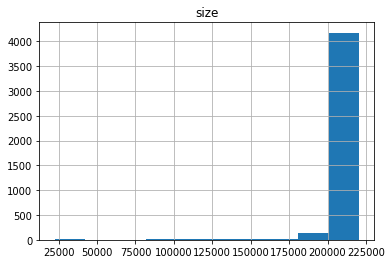

In [7]:
'# Clips with entire 10s of audio', (checdf['size']==220500).sum(), (checdf['size']==220500).sum()/checdf.shape[0]
'# Clips with <10s of audio', (checdf['size']!=220500).sum()
checdf.hist(column='size')

## Audio to Spectrogram

* Thanks to etown for the spectogram code - https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb

In [11]:
wavdata = Path('./data/google_audioset/google_audioset_Bark_Meow/')
# pngdata = Path('./data/google_audioset/google_audioset_BM_10spng/')
pngdata = Path('./data/google_audioset/google_audioset_BM_allpng/')
if pngdata.exists()==False:
    pngdata.mkdir()

In [206]:
# Code taken directly from https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb with minimal changes 
def spectrogram(wavfile):
    # for i in tqdm(checdf[checdf['size']==220500]['yid'].values):
    print(wavfile)
    fpath = wavdata/wavfile
    X,sr = librosa.load(fpath)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    Pxx, freqs, bins, im = plt.specgram(np.array(X), Fs=22050)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
#     plt.show()
    filename  = pngdata/wavfile.replace('.wav','.png')
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close('all')
#     break

In [ ]:
import multiprocessing as mp
mp.cpu_count()
with mp.Pool(6) as pool:
#     pool.map(spectrogram, checdf[checdf['size']==220500]['yid'].values)
    pool.map(spectrogram, checdf['yid'].values)

## Audio to FFT - If Spectogram is not giving accuracy - TBD - Not used can skip

## Audio to (Spectogram, FFT, Amplitude) as 3 channels - If the above two are giving good accuracy - TBD

## Creating the labels.csv file based on the dataset generated above

In [13]:
BM = pd.read_csv('./data/google_audioset/Bark_Meow_clips_metadata', sep=' ')
checdf['YID'] = checdf.yid.apply(lambda x: x.replace('.wav',''))
checdf['label'] = checdf.YID.apply(lambda x : 'Bark' if x in BM[BM.Bark==1].YTID.values else 'Meow')
checdf.shape, checdf.head()

((4397, 5),                yid    size   rate          YID label
 0  gh3vNkr5Uww.wav  220500  22050  gh3vNkr5Uww  Bark
 1  fi8ukuUuwHs.wav  220500  22050  fi8ukuUuwHs  Bark
 2  ymb1V14o9C8.wav  220500  22050  ymb1V14o9C8  Bark
 3  B4qlXfHLsPY.wav  220500  22050  B4qlXfHLsPY  Bark
 4  qAIC4MP2gf0.wav  220500  22050  qAIC4MP2gf0  Bark)

In [211]:
# checdf[checdf['size']==220500][['YID', 'label']].to_csv('./data/google_audioset/BM_10s_labels.csv', index=False)
checdf[['YID', 'label']].to_csv('./data/google_audioset/BM_all_labels.csv', index=False)

In [14]:
labelpath = Path('./data/google_audioset/BM_all_labels.csv')

## CNN classification

### ResNet 34

In [15]:
data = ImageDataBunch.from_csv(pngdata.parent,
                               pngdata.name,#ds_tfms=get_transforms(),
                              csv_labels = labelpath.name, suffix='.png' ,size=224)
data.normalize(imagenet_stats)

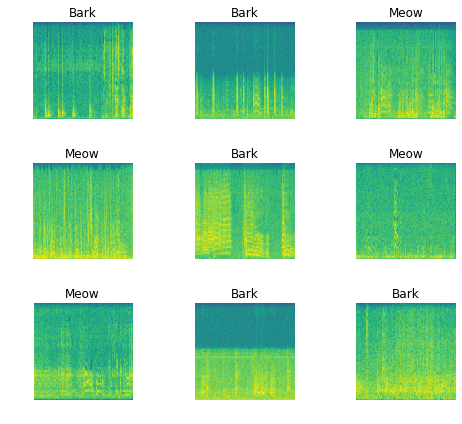

In [16]:
data.show_batch(rows=3, figsize=(7,6))

In [17]:
data.train_dl.one_batch()[0].shape

print(data.classes)
len(data.classes),data.c

torch.Size([64, 3, 217, 223])

['Bark', 'Meow']


(2, 2)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


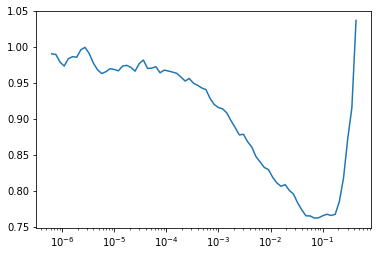

In [18]:
from fastai.vision import models
learn = ConvLearner(data, models.resnet34, metrics=[error_rate, accuracy])
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(10, 1e-2)

Total time: 01:30
epoch  train_loss  valid_loss  error_rate  accuracy
1      0.588982    0.428982    0.172373    0.827627  (00:09)
2      0.386672    0.306912    0.132231    0.867769  (00:08)
3      0.310203    0.262356    0.100354    0.899646  (00:08)
4      0.271245    0.296937    0.127509    0.872491  (00:09)
5      0.238790    0.247780    0.088548    0.911452  (00:08)
6      0.193368    0.314181    0.126328    0.873672  (00:08)
7      0.130628    0.331632    0.112161    0.887839  (00:08)
8      0.082478    0.293065    0.092090    0.907910  (00:09)
9      0.045238    0.335391    0.094451    0.905549  (00:09)
10     0.027047    0.337209    0.093270    0.906730  (00:09)



LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


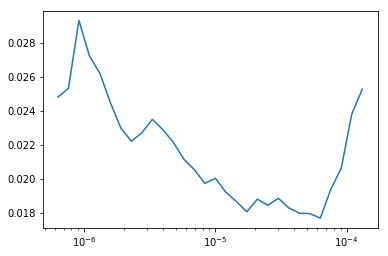

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,5*1e-5))

Total time: 01:54
epoch  train_loss  valid_loss  error_rate  accuracy
1      0.023505    0.327610    0.087367    0.912633  (00:11)
2      0.014849    0.344262    0.093270    0.906730  (00:11)
3      0.011790    0.347291    0.080283    0.919717  (00:11)
4      0.017660    0.409366    0.097993    0.902007  (00:11)
5      0.016172    0.378099    0.094451    0.905549  (00:11)
6      0.009289    0.381238    0.085006    0.914994  (00:11)
7      0.006871    0.370894    0.086187    0.913813  (00:11)
8      0.005161    0.376664    0.083825    0.916175  (00:11)
9      0.005266    0.359127    0.081464    0.918536  (00:11)
10     0.003217    0.363250    0.082645    0.917355  (00:11)



In [26]:
learn.fit_one_cycle(10, max_lr=slice(1e-3,5*1e-3))

Total time: 01:54
epoch  train_loss  valid_loss  error_rate  accuracy
1      0.019449    0.443554    0.094451    0.905549  (00:11)
2      0.056002    0.400003    0.107438    0.892562  (00:11)
3      0.088668    2.122742    0.279811    0.720189  (00:11)
4      0.115886    0.236846    0.075561    0.924439  (00:11)
5      0.094083    0.239914    0.083825    0.916175  (00:11)
6      0.059588    0.267650    0.074380    0.925620  (00:11)
7      0.050557    0.315298    0.092090    0.907910  (00:11)
8      0.024995    0.282668    0.073200    0.926800  (00:11)
9      0.012147    0.272645    0.070838    0.929162  (00:11)
10     0.005817    0.260362    0.066116    0.933884  (00:11)



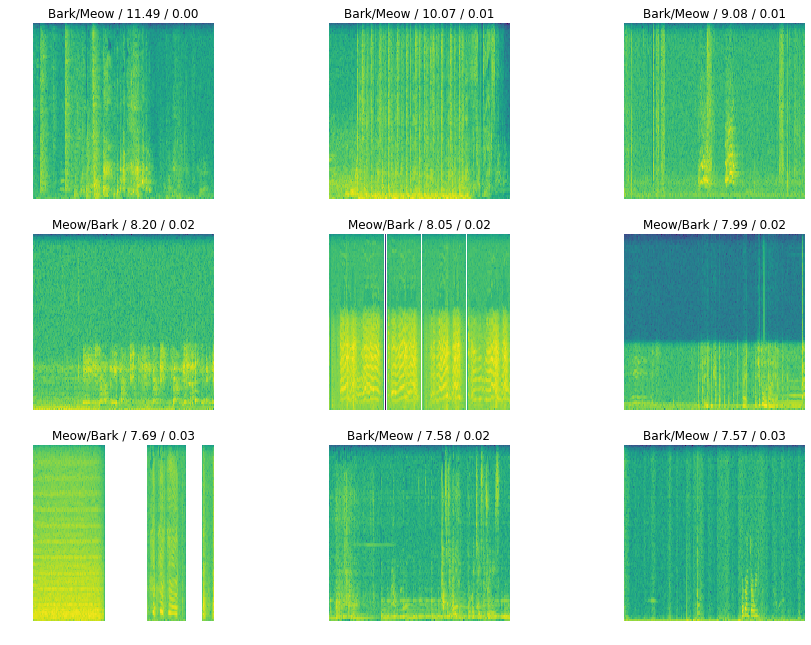

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

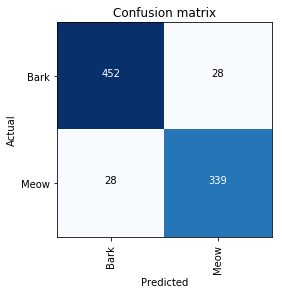

In [28]:
interp.plot_confusion_matrix()

### ResNet 50

In [44]:
data = ImageDataBunch.from_csv(pngdata.parent,
                               pngdata.name,#ds_tfms=get_transforms(),
                              csv_labels = labelpath.name, suffix='.png' ,size=224, bs=32)
data.normalize(imagenet_stats)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


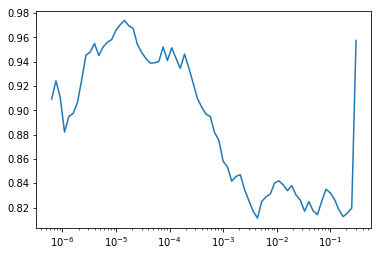

In [45]:
from fastai.vision import models
learn = ConvLearner(data, models.resnet50, metrics=[error_rate, accuracy])
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(10, 1e-2)

Total time: 02:41
epoch  train_loss  valid_loss  error_rate  accuracy
1      0.486311    0.441428    0.183371    0.816629  (00:16)
2      0.356497    0.272375    0.113895    0.886105  (00:16)
3      0.317989    1.032307    0.276765    0.723235  (00:16)
4      0.274774    0.417258    0.179954    0.820046  (00:16)
5      0.235853    0.257719    0.093394    0.906606  (00:16)
6      0.201156    0.261445    0.093394    0.906606  (00:16)
7      0.164979    0.174959    0.069476    0.930524  (00:16)
8      0.092077    0.201410    0.064920    0.935080  (00:16)
9      0.055515    0.194577    0.069476    0.930524  (00:16)
10     0.027271    0.190535    0.062642    0.937358  (00:16)



LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


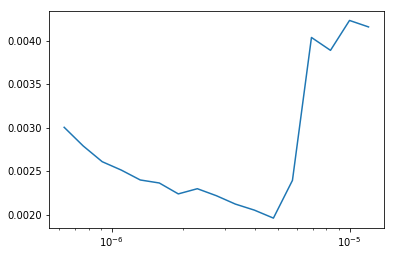

In [58]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,5*1e-5))

Total time: 03:37
epoch  train_loss  valid_loss  error_rate  accuracy
1      0.032747    0.196209    0.067198    0.932802  (00:21)
2      0.027798    0.211836    0.066059    0.933941  (00:21)
3      0.023814    0.245796    0.074032    0.925968  (00:21)
4      0.033368    0.231257    0.072893    0.927107  (00:21)
5      0.026003    0.240621    0.069476    0.930524  (00:21)
6      0.013271    0.230021    0.072893    0.927107  (00:21)
7      0.006336    0.212409    0.071754    0.928246  (00:21)
8      0.004936    0.214690    0.068337    0.931663  (00:21)
9      0.005886    0.217075    0.070615    0.929385  (00:21)
10     0.004712    0.236080    0.071754    0.928246  (00:21)



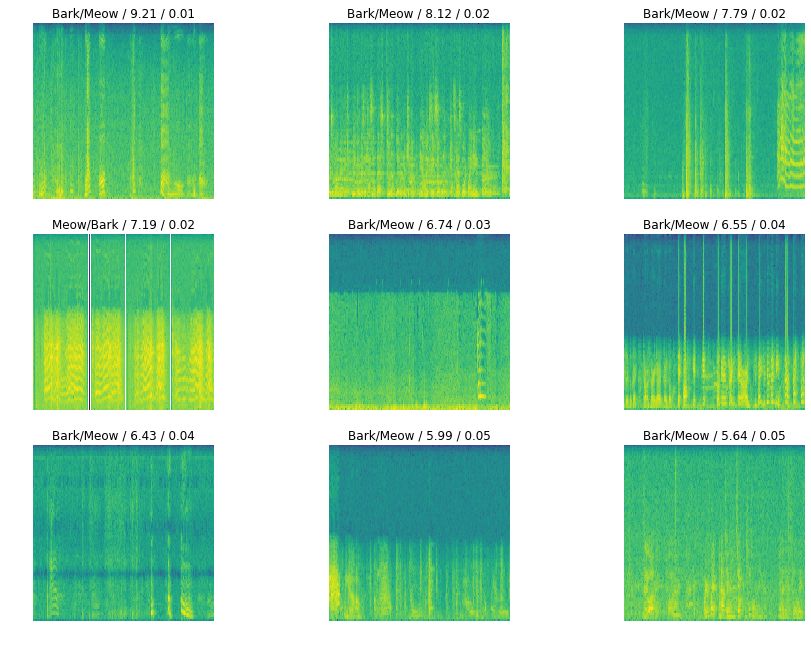

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

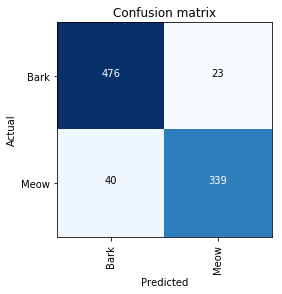

In [50]:
interp.plot_confusion_matrix()